In [17]:
import numpy as np
import scipy
import scipy.stats as sps
import scipy.fftpack as spfft
import scipy.optimize as op
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# iPython magic command for inline figures. If this command is not given, figures are generated in windows.
# An asterisk appears in the cell prompt (i.e. "In [*]:"), and the kernel stalls until the window is closed.
%matplotlib inline

In [18]:
### Light curve rebinning and segment checking ###

def rebinlc(t, flux, error, bfac):
# Bins up light curve - new bin width is increased by a factor bfac from the old bin width
# for accuracy, the length of the light curve (in original bins), ntimes, should be an integer multiple of bfac.
    ntimes = len(t)
    nbtimes = ntimes/bfac
    bin_means, bin_edges, bin_number = sps.binned_statistic(t, flux, 'mean', nbtimes)
    errorsq = np.power(error, 2.0)
    bin_errors, bin_edges, bin_number = sps.binned_statistic(t, errorsq, 'sum', nbtimes)
    bin_errors = np.sqrt(bin_errors)/bfac
    bin_t = (bin_edges[:-1]+bin_edges[1:])/2.0
    return bin_t, bin_means, bin_errors

def fix_data_segments(maxsegtime, tbin, time, rate, error):
# Real light curves have the problem that they don't often fit exactly into the fixed-length segments used to 
# measure e.g., the power spectrum or rms-flux.  Also, gaps in the data (e.g. between consecutive RXTE orbits)
# can cause segments to contain data from widely separated times unless correctly treated.  This function
# solves this problem by assigning the data to evenly time-spaced segments of the desired length, and then 
# discards any data from segments that are not completely filled.  This way, gaps are avoided and each segment
# only contains data from contiguous time bins.
    tlen = time[len(time)-1]-time[0]
    tbin_edges = np.arange(time[0], (time[0]+maxsegtime*(int(tlen/maxsegtime)+2)), maxsegtime)
    segnbin = int(maxsegtime/tbin)
    bin_rate, bin_edges, bin_number = sps.binned_statistic(time, rate, 'mean', bins=tbin_edges)
    bins_in_seg = np.array([np.sum(bin_number == i) for i in range(1, len(bin_rate)+1)])
    rbtime = np.zeros(segnbin*np.sum(bins_in_seg == segnbin))
    rbrate = np.zeros(segnbin*np.sum(bins_in_seg == segnbin))
    rberror = np.zeros(segnbin*np.sum(bins_in_seg == segnbin))
    rbbin_number = np.zeros(segnbin*np.sum(bins_in_seg == segnbin))
    j = 0
    for i in range(0, len(time)):
        if (bins_in_seg[bin_number[i]-1] == segnbin):
            rbtime[j] = j*tbin
            rbrate[j] = rate[i]
            rberror[j] = error[i]
            rbbin_number[j] = bin_number[i]-1
            j = j+1                    
    return rbtime, rbrate, rberror, rbbin_number

### Power spectrum measurement ###

def make_psd(maxsegtime,bfac,tbin,rbrate,rberror):
# Makes a binned power spectrum (in rms-squared normalisation) from an input light curve consisting of consecutive
# whole segments of the duration (maxsegtime) required for the power spectrum (set using fix_data_segments).
# The power spectrum is binned over segments and also in frequency (with geometrically spaced bins, spaced by a 
# factor bfac).
    segnbin = int(maxsegtime/tbin)
    nseg = len(rbrate)/segnbin
    segrate = np.zeros(segnbin)
    segerror = np.zeros(segnbin)
    segerrsq_av = 0.0
    per = np.zeros(segnbin/2)
    persq = np.zeros(segnbin/2)
    # First measure the periodogram (unnormalised mod-squared FT) and its square and record the average over
    # all segments.
    for i in range(0,nseg-1):
        for j in range(0,segnbin-1):
            segrate[j] = rbrate[i*segnbin+j]
            segerror[j] = rberror[i*segnbin+j]
            
        segsqmean = np.square(np.mean(segrate))
        segerrsq_av = segerrsq_av + np.mean(np.square(segerror))/segsqmean
        f3 = np.fft.fft(segrate) # For the Fourier transform
        p3 = np.square(np.abs(f3))/segsqmean # For the periodogram (mod-squared of FT)
        # Note that the periodogram is normalised by the squared mean flux of the segment, i.e. not by the
        # squared mean of the whole light curve - this deals with scatter introduced by the rms-flux relation.
        per = per + p3[1:(1+len(p3)/2)] # remember that the upper value of the range is excluded!
        persq = persq + np.square(p3[1:(1+len(p3)/2)])
    per = per/nseg
    persq = persq/nseg
    minfreq = 1./(tbin*segnbin) # the minimum Fourier frequency
    freq = np.linspace(minfreq, len(per)*minfreq,len(per))
    binfreq = np.zeros(1)
    binper = np.zeros(1)
    binpersq = np.zeros(1)
    ninbin = np.zeros(1)
    fstart = freq[0]
    binfreqsum = 0.0
    binpersum = 0.0
    binpersqsum = 0.0
    ninbinsum = 0
    j = 0
    # Now bin up in frequency
    for i in range (0,len(freq)): # Now bin in frequency        
        if (freq[i] > fstart*bfac):
            if (j == 0):
                binfreq[0] = binfreqsum
                binper[0] = binpersum
                binpersq[0] = binpersqsum
                ninbin[0] = ninbinsum
            else:
                binfreq = np.append(binfreq,binfreqsum)
                binper = np.append(binper,binpersum)
                binpersq = np.append(binpersq,binpersqsum)
                ninbin = np.append(ninbin,ninbinsum)
            binfreqsum = 0.0
            binpersum =  0.0
            binpersqsum = 0.0
            ninbinsum = 0
            fstart = freq[i]
            j = j + 1
        binfreqsum = binfreqsum + freq[i]
        binpersum = binpersum + per[i]
        binpersqsum = binpersqsum + persq[i]
        ninbinsum = ninbinsum + 1

    binfreq = binfreq / ninbin
    binper = binper / ninbin
    binpersq = binpersq / ninbin
    # Calculate errors and apply the rms^2 normalisation
    binper_error = np.sqrt(np.divide((binpersq - np.square(binper)),ninbin)/nseg)
    A_rms = 2*tbin/segnbin
    psd = A_rms*binper
    psd_error = A_rms*binper_error
    noise_level = 2.0*tbin*segerrsq_av/nseg # return also the expected Poisson noise level
    return binfreq, psd, psd_error, noise_level


### Histogram measurement and plotting ###

def mkfluxhist(flux, nbins, mincounts):
    
    counts, edges = np.histogram(flux, bins=nbins, range=[min(flux),max(flux)], density=False)
    counts2, edges2 = histrebin(mincounts,counts,edges)
    bcent = (edges2[:-1]+edges2[1:])/2.
    bwidths = np.diff(edges2) # calculates the width of each bin
    cdens = counts2/bwidths # determines the densities
    cdens_err = np.sqrt(counts2)/bwidths # calculate the errors
    cdens = cdens/np.sum(counts2)
    cdens_err = cdens_err/np.sum(counts2)
    return edges2, bcent, bwidths, cdens, cdens_err

def histrebin(mininbin,counts,edges): 
# rebins a histogram so there are at least mininbin counts per bin
    edges2=np.zeros(1)
    counts2=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges2[0]=edges[0]
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts2[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts2=np.append(counts2,countsum)
            edges2=np.append(edges2,edges[i])
            countsum=0        
    return counts2, edges2

def my_plot_hist(bcentres, bwidths, cdens, cdens_err, modflux, modxvals, model, col, form, fillq):
# Bespoke plotting for the flux histograms using both the integrated model values and the model values (modxvals) 
# which must be pre-calculated using the integrate_model function - this allows the model to be correctly plotted
# against the data.  The real integrated model values are used to plot the data/model ratio beneath the
# main histogram.
    ax1.errorbar(bcentres, cdens, xerr=bwidths/2., yerr=cdens_err, marker=form, c=col, mfc=fillq, linestyle="",
                mec=col)
    ax1.plot(modxvals, modflux, color=col, ls='solid')
    ax1.set_xlabel("Flux", fontsize=20)
    ax1.set_ylabel("Density", fontsize=20)
    ax1.tick_params(labelsize=16)
    ax2.errorbar(bcentres, cdens/modelvals, xerr=bwidths/2., yerr=cdens_err/modelvals, marker=form, c=col, mfc=fillq,
                mec=col, linestyle="")
    ax2.axhline(y=1.0,linewidth=2,linestyle='dashed',c="black")
    ax2.set_xlabel("Normalised flux", fontsize=20)
    ax2.set_ylabel("Data/Model ratio", fontsize=20)
    ax2.tick_params(labelsize=16)    
    x1,x2,y1,y2 = ax1.axis()
    ax1.axis((0.0,4.3,-0.1,1.7))
    ax2.axis((0.0,4.3,0.0,3.2))
    return

### rms-flux measurement and binning ###

def rmsflux(t, flux, error, nsegbins):
# Actually measures the (unbinned) intrinsic ('excess') variances of light curve segments of length nsegbins.
    ntimes = len(t)
    nseg = ntimes/nsegbins
    fluxsq = np.power(flux, 2.0)
    errorsq = np.power(error, 2.0)
    bin_flux, bin_edges, bin_number = sps.binned_statistic(t, flux, 'mean', nseg)
    bin_fluxsq, bin_edges, bin_number = sps.binned_statistic(t, fluxsq, 'mean', nseg)
    bin_errsq, bin_edges, bin_number = sps.binned_statistic(t, errorsq, 'mean', nseg) # average error squared is
    # the expected contribution of the observational error to the total variance of the segment.  This is subtracted
    # to give the intrinsic variance.
    bin_rmssq = ((nsegbins/(nsegbins-1))*(bin_fluxsq - np.power(bin_flux, 2.0)))-bin_errsq
    return bin_flux, bin_rmssq

def binrmsflux(flux, rms, nbins, mininbin):
# Bins up the rms-flux relation, first splitting the range of flux into nbins equal-width bins, but requiring at 
# least mininbin values per bin, so that errors are close to normal if mininbin is set to be large.
# Errors are calculated using the standard error of the values in each flux bin, however since his version is 
# designed to bin up the variances calculated by the current rmsflux function, it takes the sqrt of the binned
# variance and propagates the error accordingly.
    rmssq = np.power(rms, 2.0)  # we need to record the squares of the input values, so we can determine the
    # standard deviation and hence the error later.
    bin_rms, bin_edges, bin_number = sps.binned_statistic(flux, rms, 'mean', nbins)
    bin_rmssq, bin_edges, bin_number = sps.binned_statistic(flux, rmssq, 'mean', nbins)
    bin_flux = [flux[bin_number == i].mean() for i in range(1, len(bin_rms)+1)]
    bin_num = np.bincount(bin_number)
    bin_num2 = np.zeros(1)
    bin_flux2 = np.zeros(1)
    bin_rms2 = np.zeros(1)
    bin_rmssq2 = np.zeros(1)
    binnedflux=0.
    binnedrms=0.
    binnedrmssq=0.
    i=0
    countsum=0
    firstbin_flag = 1
    while i < len(bin_flux):
        j=i+1
        countsum=countsum+bin_num[j]
        binnedflux=binnedflux+bin_flux[i]*bin_num[j]
        binnedrms=binnedrms+bin_rms[i]*bin_num[j]
        binnedrmssq=binnedrmssq+bin_rmssq[i]*bin_num[j]
        i=i+1
        if countsum >= mininbin and (sum(bin_num[j:]) >= mininbin or i == len(bin_flux)):  # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                bin_flux2[0]=binnedflux
                bin_rms2[0]=binnedrms
                bin_rmssq2[0]=binnedrmssq
                bin_num2[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                bin_flux2=np.append(bin_flux2,binnedflux)
                bin_rms2=np.append(bin_rms2,binnedrms)
                bin_rmssq2=np.append(bin_rmssq2,binnedrmssq)
                bin_num2=np.append(bin_num2,countsum)
            binnedflux=0.
            binnedrms=0.0
            binnedrmssq=0.0
            countsum=0        
    bin_flux2=np.divide(bin_flux2,bin_num2)
    bin_rms2=np.divide(bin_rms2,bin_num2)
    bin_rmssq2=np.divide(bin_rmssq2,bin_num2)
    bin_err = np.sqrt(bin_rmssq2 - np.square(bin_rms2))/np.sqrt(bin_num2)
    bin_rms2 = np.sqrt(bin_rms2)
    bin_err = np.multiply(bin_err,np.divide(0.5, bin_rms2))
    return bin_flux2, bin_rms2, bin_err
        
### Routines for model fitting and plotting ###

def ChiSq_Integ(parm, bins, yval, dy): 
# the weighted least-squares for an array of upper and lower bin edges (xval1 and xval2) fitted with the integral 
# over the bin of the generic model my_model
    lognorm = scipy.stats.lognorm(s = parm[0], loc = parm[1], scale = parm[2])
    i = 0
    ymod = np.zeros(len(yval))
    for val in bins[:-1]:
        ymod[i] = lognorm.cdf(bins[i+1])-lognorm.cdf(bins[i])
        ymod[i] = ymod[i]/(bins[i+1]-bins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1
        
    return sum(pow((yval-ymod)/dy,2))

def integrate_model(parm, bins): 
# If we want to be really 'correct' with our plotting of binned 'histogram' type data, we should ensure that 
# the steps match the bin edges - there is no simple way that we have 
# found to do this in Python.  One solution would be not to plot model points at the bin centres 
# but to output 2 model values at each bin edge (one equal to the model value in the bin below the edge, 
# the other equal to the model value in the bin below the edge). 
# The correct steps could then be produced simply by drawing a connecting line through all these points.
# Here we implement this approach and produce the correct-format model energies and model values for plotting
# a "bespoke" stepped model function.
    lognorm = scipy.stats.lognorm(s = parm[0], loc = parm[1], scale = parm[2])
    i = 0
    j = 0
    xmod = np.zeros(2*len(bins)-2)
    ymod = np.zeros(2*len(bins)-2)
    model = np.zeros(len(bins)-1)
    for value in bins[:-1]:
        mod = lognorm.cdf(bins[i+1])-lognorm.cdf(bins[i])
        mod = mod/(bins[i+1]-bins[i])  # we now divide by the bin width to match the counts density
        model[i] = mod
        # units of our data
        xmod[j] = bins[i]
        ymod[j] = mod
        j = j+1
        xmod[j] = bins[i+1]
        ymod[j] = mod
        j = j+1            
        i=i+1
    return xmod, ymod, model

def fit_psd(freq,psd,psd_error,noise_level,*parm):
# Fits the power spectrum with the multi-Lorentzian model (plus a constant for the Poisson noise level).  
# The q-value of the highest-frequency Lorentzian is frozen at 0.3, since it is strongly degenerate with the 
# other parameters of that component.
    result =  op.minimize(ChiSq, parm, args=(noise_level,multi_lorentz,freq,psd,psd_error), method='L-BFGS-B',
                         bounds=[(None,None),(None,None),(None,None),(None,None),(None,None),(None,None),
                                 (None,None),(0.3,0.3),(None,None)])
    return result

def ChiSq(parm, const, my_model, xval, yval, dy): # the weighted least-squares
# Chi-squared used by fit_psd
    ymod = my_model(xval, *parm) + const
    chisq = sum(pow((yval-ymod)/dy,2))
    return chisq

### Model functions ###

def lorentz_q(f, f_pk, q, rms):  
# Form of the Lorentzian function defined in terms of peak frequency and quality factor q
# e.g. see Pottschmidt et al. 2003, A&A, 407, 1039 for more info
    f_res=f_pk/np.sqrt(1.0+(1.0/(4.0*q**2)))
    r=rms/np.sqrt(0.5-np.arctan(-2.0*q)/np.pi)
    lorentz=((1/np.pi)*2*r**2*q*f_res)/ \
    (f_res**2+(4*q**2*(f-f_res)**2))
    return lorentz

def lorentz_fwhm(f, f_cent, fwhm, norm): 
# Traditional form of the Lorentz function
    lorentz = norm * (fwhm/(2.*np.pi))/((f-f_cent)**2 + (fwhm/2.0)**2)
    return lorentz

def linfit(x, *parm):
# A simple linear model to fit the rms-flux relations with
    linfit = parm[0]*x + parm[1]
    return linfit

def multi_lorentz(freq, *parm):
# A 3-Lorentzian model for the power spectrum.
    f_pk1 = parm[0]
    q1 = parm[1]
    rms1 = parm[2]
    f_pk2 = parm[3]
    q2 = parm[4]
    rms2 = parm[5]
    f_pk3 = parm[6]
    q3 = parm[7]
    rms3 = parm[8]    
    lorentz_comb = lorentz_q(freq, f_pk1, q1, rms1) + lorentz_q(freq, f_pk2, q2, rms2) + lorentz_q(freq, f_pk3, q3, rms3)
    return lorentz_comb

### Light curve simulation ###

def tksim(tbin, ntimes, psmodel, pspar):
# Implementation of Timmer & Koenig method to simulate a noise process for an arbitrary power-spectral shape 
# (Timmer & Koenig, 1995, A&A, 300, 707), based on an original Python implementation by Dimitrios Emmanoulopoulos
    nfreq = ntimes/2
    f = np.arange(1.0, nfreq+1, 1.0)/(ntimes*tbin)
    modpow = np.multiply(psmodel(f, *pspar),nfreq/tbin)
    gdev1=np.random.normal(size=(1,nfreq))
    gdev2=np.random.normal(size=(1,nfreq))
    ft_re=np.multiply(np.sqrt(np.multiply(modpow,0.5)),np.reshape(gdev1,nfreq))  
    ft_im=np.multiply(np.sqrt(np.multiply(modpow,0.5)),np.reshape(gdev2,nfreq))
    ft_pos=np.zeros(nfreq,complex)  

    for i in range(nfreq):  
      ft_pos[i]=complex(ft_re[i],ft_im[i]) 
    ft_neg=np.zeros(nfreq,complex)  
    for i in range(nfreq): 
      ft_neg[i]=ft_pos[i].conjugate() # sets negative frequencies as complex conjugate of positive (for real-valued LC)

    ft_full=np.append(ft_pos,ft_neg[nfreq-2::-1]) # append -ve frequencies to +ve.  Note that scipy.fftpack orders
    # the FT array as follows: y[0] = zero freq, y[1:nfreq-1] ascending +ve freq values, y[nfreq:2*nfreq-1] ascending
    # (i.e. less -ve) -ve freq values.  This means that the Nyquist freq value used at y[nfreq] is actually the -ve
    # frequency value.
    # For our even-valued nfreq this doesn't matter since we must set the Nyquist freq value to be real anyway 
    # (see below).  
    ft_full=np.insert(ft_full,0,complex(0.0,0.0))  # Set zero-freq (i.e. 'DC component' or mean) to zero
    ft_full[nfreq]=complex(ft_full.real[nfreq],0.0) # For symmetry need to make Nyquist freq value real - note that
    # neglecting to do this causes a small imaginary component to appear in the inverse FFT
    ift_full=np.fft.ifft(ft_full)                            
    lc=ift_full.real
    return lc


We first load in the real data, determine its power spectrum and fit with a 3-Lorentzian model.

308138  time bins recorded
283648  time bins kept after ensuring filled light curve segments


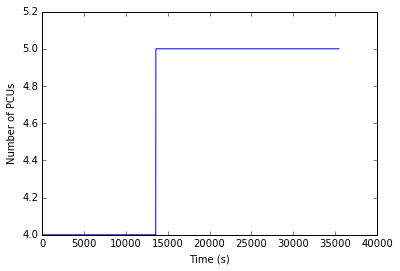

Noise level is:  0.000387994531379
Best-fitting parameters (nu_peak, q and rms, x 3):  [ 0.1123511   0.12015278  0.23024797  0.79453849  0.31234013  0.19169484
  9.99995481  0.3         0.20004872]
Chi-squared:  81.2525912269  for  67  d.o.f.


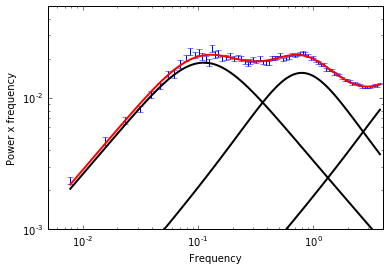

In [19]:
maxsegtime = 128.0  # Length of the light curve segments used to measure the power spectrum: we will select only
# the subset of these segments which are filled with data points contiguous in time, with no gaps or empty bins. 
tbin = 0.125 # Time bin size
bfac = 1.05 # Geometric frequency binning factor for the power spectrum

cygx1lc = np.loadtxt("cygx1lc_0p125s.dat")

time = cygx1lc[:,0]
rate = cygx1lc[:,1]
error = cygx1lc[:,2]
print len(time)," time bins recorded"
rbtime, rbrate, rberror, rbbin_number = fix_data_segments(maxsegtime, tbin, time, rate, error) # Ensures that we only
# use segments which are complete with contiguous time bins and do not contain gaps in the light curve.
mean_rbrate = np.mean(rbrate)  # Mean rate of the modified light curve.
print len(rbtime)," time bins kept after ensuring filled light curve segments"
# To properly account for Poisson noise we need to know how many RXTE PCA PCUs are switched on at 
# a given time.  The data are normalised to be per PCU, but we can work this out from the size of the error bars,
# which depend on the total count rate.
npcu = np.divide(rbrate,np.multiply(tbin,np.square(rberror)))
npcu = np.rint(npcu) # the measured values are slightly below the corresponding integer numbers of PCUs
# so we round to the nearest integer (note: this effect is likely due to the subtraction of the relatively
# small background component from the light curves - we do not include this component in our simulations)

plt.plot(rbtime,npcu) # We plot our time series for the number of PCUs switched on.
plt.xlabel('Time (s)')
plt.ylabel('Number of PCUs')
plt.show()

psd_freq, psd, psd_error, nslev = make_psd(maxsegtime,bfac,tbin,rbrate,rberror) # Measure power-spectrum
print "Noise level is: ", nslev

parm = [0.1, 0.5, 0.1, 1.0, 0.3, 0.1, 10.0, 0.3, 0.1] # Starting parameters for 3-Lorentzian fit

result = fit_psd(psd_freq,psd,psd_error,nslev,parm)
print "Best-fitting parameters (nu_peak, q and rms, x 3): ", result.x
print "Chi-squared: ", result.fun, " for ", len(psd_freq)-len(parm)," d.o.f."

parm2 = result.x[:] # Sets the 3-Lorentzian model parameters to be the best-fitting values (for plotting purposes)

# Now plot the (noise-subtracted) power spectrum and model (and individual Lorentzian components) to check the fit.  
# We plot as frequency*power, since this is easier to interpret.

plt.errorbar(psd_freq, (psd-nslev)*psd_freq, yerr=psd_error*psd_freq, linestyle="")
plt.xlabel('Frequency')
plt.ylabel('Power x frequency')
plt.yscale('log')
plt.xscale('log')
x1,x2,y1,y2 = plt.axis()
plt.axis((0.005,4.0,1e-3,0.05))

model_pow = psd_freq*multi_lorentz(psd_freq,*parm2)
plt.plot(psd_freq,model_pow,color='red',lw=2.0)
parm_l1 = parm2[0:3]  # Record best-fitting parameters for each Lorentzian so we can plot them
parm_l2 = parm2[3:6]
parm_l3 = parm2[6:9]

plt.plot(psd_freq,psd_freq*lorentz_q(psd_freq,*parm_l1),color='black',lw=2.0)
plt.plot(psd_freq,psd_freq*lorentz_q(psd_freq,*parm_l2),color='black',lw=2.0)
plt.plot(psd_freq,psd_freq*lorentz_q(psd_freq,*parm_l3),color='black',lw=2.0)
plt.show()

lor_params = np.copy(parm2) # Keep a copy of the best-fitting parameters for later use.

Next we measure the observed flux distribution (with flux normalised by the mean count rate) and fit it with a lognormal model, in order to obtain the flux offset parameter which we can use when simulating a lognormally distributed light curve using the method of UMV05.

Fit parameters [sigma, tau, ln(mu)] :  [ 0.35684341  0.15597638  0.79163736]
Chi-squared :  86.575100838  for  52  d.o.f


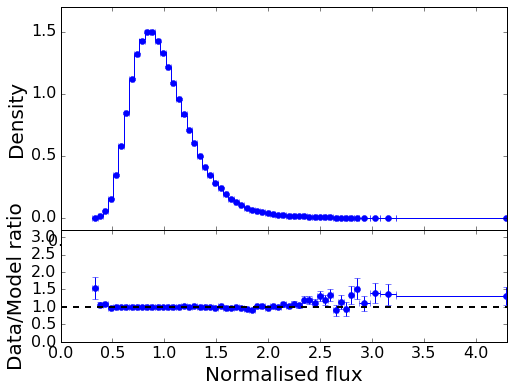

In [20]:
norm_rate = rbrate/np.mean(rbrate)  # Normalise the count rate and error by the mean.
norm_error = rberror/np.mean(rbrate)

bedges, bcent, bwidths, cdens, cdens_err = mkfluxhist(norm_rate, 100, 20)

p0 = [0.3, 0.0, 1.0]  # Starting parameters for the lognormal fit (sigma, tau and ln(mu) from eqn. 3 in UMV05)

result =  op.minimize(ChiSq_Integ, p0, args=(bedges,cdens,cdens_err), method='L-BFGS-B', 
                     bounds=[(0.0,None),(None,None),(None,None)])  # Sigma forced to be +ve
print "Fit parameters [sigma, tau, ln(mu)] : ",result.x 
print "Chi-squared : ",result.fun," for ",len(cdens)-3," d.o.f" 

lnpar = np.copy(result.x)  # Save lognormal fit parameters

modens, modflux, modelvals = integrate_model(result.x, bedges) # Calculate values for plotting model correctly on
# the histogram

fig = plt.subplots(2,1,figsize=(8,6))  # Plot the flux distribution, model, and the data/model ratio
gs1 = gridspec.GridSpec(3,3)
gs1.update(hspace=0)
ax1 = plt.subplot(gs1[:-1,:])
ax2 = plt.subplot(gs1[-1,:])
my_plot_hist(bcent, bwidths, cdens, cdens_err, modflux, modens, modelvals, "blue", "o", "blue")

Next we simulate 'fake' lightcurves using the implementation of the K16 model described in the paper, as well as the UMV05 exponentiation approach.

In [21]:
#  Now make two fake light curves based on the fitted Lorentzian model parameters, one for the Koen model where
#  the lowest-frequency Lorentzian light curve is multiplied by the light curve due to the sum of the two
#  higher-frequency Lorentzians, and one for the exponentiated light curve (following UMV05)

np.random.seed(1)  # For reproducibility, we set the random seed at the start

ntimes = int(np.power(2.0, int(np.log(len(rbtime))/np.log(2.))+1))*8 # Ensure that the simulations are longer than
# the real data

tbin_small = tbin/8.0  # We generate the simulated light curves with finer binning to properly deal with higher 
# frequency aliasing and sidebands
time = np.arange(0.0, ntimes*tbin_small, tbin_small)  # Set up array of bin times

# First the Koen model curve.  Note that since the T&K generated light curves have normal flux 
# distributions, there is a risk that the K16 light curve components have -ve fluxes, in which case bad things
# can happen - e.g. besides having -ve fluxes which are unphysical we can also have two -ve values multiplying to make 
# a sudden sharp step to a +ve value, i.e. the resulting power spectrum can itself be distorted.
# To deal with this problem, we force the light curves of each component to have a very small, but positive, 
# limiting value.
print "*********SIMULATING K16 MODEL LIGHTCURVE***********"
lc1 = 1. + tksim(tbin_small, ntimes, lorentz_q, parm_l1)  # Made with the lowest-frequency Lorentzian
lc1[lc1 < 0.0] = 0.001   # replace -ve values with v. small value
lc2 = 1. + tksim(tbin_small, ntimes, lorentz_q, parm_l2) + tksim(tbin_small, ntimes, lorentz_q, parm_l3) # Made
# with the sum of the two higher Lorentzians
lc2[lc2 < 0.0] = 0.001   # replace -ve values with v. small value
lcout = np.multiply(lc1, lc2) # Multiply together a la K16
lcout_error = np.zeros(ntimes)
time_rebin, rate_rebin, error_rebin = rebinlc(time, lcout, lcout_error, 8) # Now bin up to original time resolution

lclen = len(rbtime)  # Now we use the length of the real data (after it was rebinned to whole segments) to select
# a matched-length subset of the simulated light curve
rbtime_koen = time_rebin[0:lclen]
rbrate_koen = rate_rebin[0:lclen]
rbrate_koen = rbrate_koen*npcu*mean_rbrate/np.mean(rbrate_koen) # To properly account for Poisson noise
# we must correct the count rate for the number of PCUs switched on.
rbrate_koen = np.random.poisson(rbrate_koen*tbin)/tbin
rberror_koen = np.sqrt(rbrate_koen*tbin)/tbin
rbrate_koen = rbrate_koen/npcu # Now correct back to count rate per pcu
rberror_koen = rberror_koen/npcu

print "Simulated mean count rate: ",np.mean(rbrate_koen)
print "Final simulated fractional rms (including noise): ",np.std(rbrate_koen)/np.mean(rbrate_koen)

# We next follow the approach of UMV05, to simulate an 'exponentiated' light curve, which has the lognormal flux
# distribution built in.  
print "*********SIMULATING UMV05 MODEL LIGHTCURVE***********"
exp_params = np.copy(lor_params) # Make a copy of the Lorentzian parameters which we can use to modify the input
# Lorentzian rms amplitudes.

# For a more useful comparison with the data, we can also include a flux offset which 
# in normalised flux units is equal to the tau parameter (lnpar[1]) obtained from fitting the lognormal distribution
# to the flux distribution of the real data.  To start with, we work out a correction to the rms^2 of the simulated
# lightcurve due to the additional offset (i.e. the variable part of the light curve has a larger fractional rms^2
# than if there is no flux offset):
combrmssq = (np.square(lor_params[2])+np.square(lor_params[5])+np.square(lor_params[8]))*np.square(1./(1.-lnpar[1]))
# Exponentiation increases the variability amplitude, so now we follow UMV05 and apply a correction to the rms of
# each Lorentzian such that when the light curve is exponentiated we get back to the original variability amplitude
# (and hence amplitude of the power spectrum).
combrmssq2 = (np.square(lor_params[2])+np.square(lor_params[5])+np.square(lor_params[8]))
linrmssq = np.log(combrmssq+1.0)
exp_params[2] = exp_params[2]*np.sqrt(linrmssq/combrmssq2)
exp_params[5] = exp_params[5]*np.sqrt(linrmssq/combrmssq2)
exp_params[8] = exp_params[8]*np.sqrt(linrmssq/combrmssq2)

lc1 = tksim(tbin_small, ntimes, multi_lorentz, exp_params)

# Check our parameters while doing the exponentiation to see the corrections worked
print "Combined original and corrected input linear rms-squared: ",combrmssq, linrmssq
print "Original parameters ", lor_params
print "Corrected parameters ", exp_params

lcout = np.exp(lc1)
lcout = lcout/np.mean(lcout)
print "Fractional rms of simulated light curve = ", np.std(lcout)
lcout = lcout*(1.-lnpar[1])+lnpar[1]  # Now include the constant offset component
print "Fractional rms with offset = ", np.std(lcout)

lcout_error = np.zeros(ntimes)
time_rebin, rate_rebin, error_rebin = rebinlc(time, lcout, lcout_error, 8) # rebin to original resolution

lclen = len(rbtime)
rbtime_exp = time_rebin[0:lclen]
rbrate_exp = rate_rebin[0:lclen]
rbrate_exp = rbrate_exp*npcu*mean_rbrate/np.mean(rbrate_exp)
rbrate_exp = np.random.poisson(rbrate_exp*tbin)/tbin
rberror_exp = np.sqrt(rbrate_exp*tbin)/tbin
rbrate_exp = rbrate_exp/npcu
rberror_exp = rberror_exp/npcu

print "Simulated mean count rate: ",np.mean(rbrate_exp)
print "Final simulated fractional rms (including noise): ",np.std(rbrate_exp)/np.mean(rbrate_exp)

*********SIMULATING K16 MODEL LIGHTCURVE***********
Simulated mean count rate:  1151.19851083
Final simulated fractional rms (including noise):  0.305727603196
*********SIMULATING UMV05 MODEL LIGHTCURVE***********
Combined original and corrected input linear rms-squared:  0.182179852218 0.167360066646
Original parameters  [ 0.1123511   0.12015278  0.23024797  0.79453849  0.31234013  0.19169484
  9.99995481  0.3         0.20004872]
Corrected parameters  [ 0.1123511   0.12015278  0.26146705  0.79453849  0.31234013  0.21768654
  9.99995481  0.3         0.22717311]
Fractional rms of simulated light curve =  0.416048019314
Fractional rms with offset =  0.351154357296
Simulated mean count rate:  1151.314989
Final simulated fractional rms (including noise):  0.300895341416


Now we produce and plot power spectra for our real and simulated (K16 and UMV05) light curves:

Noise level is:  0.000387994531379
Noise level is:  0.000380160482195
Noise level is:  0.000380171519124


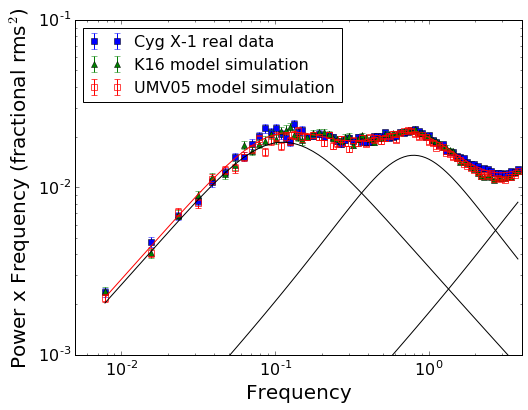

In [22]:
psd_freq, psd, psd_error, nslev = make_psd(maxsegtime,bfac,tbin,rbrate,rberror)
print "Noise level is: ", nslev

psd_freq_koen, psd_koen, psd_error_koen, nslev_koen = make_psd(maxsegtime,bfac,tbin,rbrate_koen,rberror_koen)
print "Noise level is: ", nslev_koen

psd_freq_exp, psd_exp, psd_error_exp, nslev_exp = make_psd(maxsegtime,bfac,tbin,rbrate_exp,rberror_exp)
print "Noise level is: ", nslev_exp

fig = plt.subplots(figsize=(8,6))

plt.errorbar(psd_freq, (psd-nslev)*psd_freq, yerr=psd_error*psd_freq, linestyle="", fmt='s', color='b', 
             label='Cyg X-1 real data')
plt.errorbar(psd_freq_koen, (psd_koen-nslev_koen)*psd_freq_koen, yerr=psd_error_koen*psd_freq_koen, linestyle="",
             fmt='^', color='g', label='K16 model simulation')
plt.errorbar(psd_freq_exp, (psd_exp-nslev_exp)*psd_freq_exp, yerr=psd_error_exp*psd_freq_exp, linestyle="", 
             fmt='s', color='r', mfc='None', mec='red', markeredgewidth=0.7, label='UMV05 model simulation')
plt.xlabel('Frequency',fontsize=20)
plt.ylabel('Power x Frequency (fractional rms$^{2}$)',fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.tick_params(axis='both', labelsize=16)
x1,x2,y1,y2 = plt.axis()
plt.axis((0.005,4.0,1e-3,0.1))

model_pow = psd_freq*multi_lorentz(psd_freq,*lor_params)
plt.plot(psd_freq,model_pow,color='red',lw=1.0)
parm_l1 = parm2[0:3]
parm_l2 = parm2[3:6]
parm_l3 = parm2[6:9]
plt.plot(psd_freq,psd_freq*lorentz_q(psd_freq,*parm_l1),color='black',lw=1.0)
plt.plot(psd_freq,psd_freq*lorentz_q(psd_freq,*parm_l2),color='black',lw=1.0)
plt.plot(psd_freq,psd_freq*lorentz_q(psd_freq,*parm_l3),color='black',lw=1.0)

plt.legend(loc='upper left', fontsize=16)
#plt.savefig("psds.pdf", bbox_inches='tight')  # uncomment in order to also save the plot as a pdf
plt.show()

Next we look at rms-flux relations (normalised by the mean count rate) on long and short time-scales for the real data and our simulated K16 and UMV05 light curves. 

**********Measure and plot the short time-scale rms-flux relations***********
For the real data:
Chisq  98.6157150242  for  12  dof
For parameters:  [ 0.24111333 -0.05714464]
For the K16 simulated data:
Chisq  11.3916129293  for  11  dof
For parameters:  [ 0.12713076  0.06334303]
For the UMV05 simulated data:
Chisq  23.7470631848  for  11  dof
For parameters:  [ 0.22934734 -0.04697133]


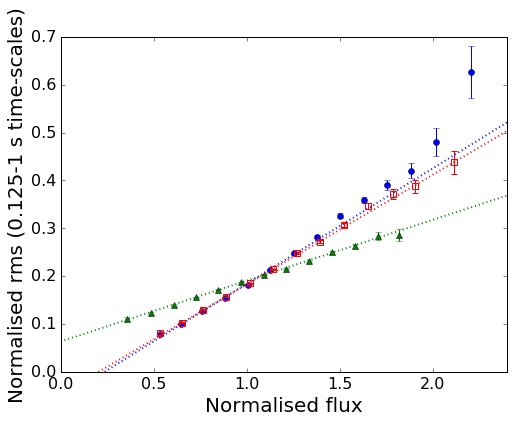

**********Measure and plot the long time-scale rms-flux relations***********
For the real data:
Chisq  1.81263030566  for  3  dof
For parameters:  [ 0.22249408 -0.07043643]
For the K16 simulated data:
Chisq  4.0355502547  for  4  dof
For parameters:  [ 0.04815889  0.10383711]
For the UMV05 simulated data:
Chisq  1.91566567297  for  4  dof
For parameters:  [ 0.28383292 -0.13552892]


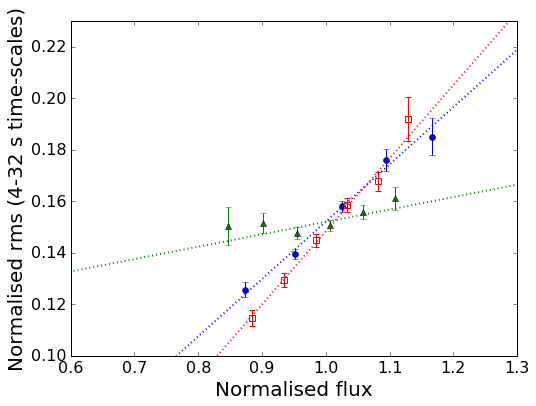

In [23]:
# First normalise the rates and errors by the mean rates.
norm_rate = rbrate/np.mean(rbrate)
norm_error = rberror/np.mean(rbrate)
norm_rate_koen = rbrate_koen/np.mean(rbrate_koen)
norm_error_koen = rberror_koen/np.mean(rbrate_koen)
norm_rate_exp = rbrate_exp/np.mean(rbrate_exp)
norm_error_exp = rberror_exp/np.mean(rbrate_exp)

# We will first look at the short time-scale rms-flux relations, calculated for light curve segments containing
# 8 bins (i.e. 1 s duration):
print "**********Measure and plot the short time-scale rms-flux relations***********"

fig = plt.subplots(figsize=(8,6))
modflux = np.arange(0.0, 2.6, 0.1) # This is the flux range used for plotting the linear model and is specific to
# the short time-scale relations we determine.

# First the real data:
flux, rms = rmsflux(rbtime, norm_rate, norm_error, 8) # Determine variances for 1s segments
bin_flux, bin_rms, bin_err = binrmsflux(flux, rms, 16, 20) # Bin the variances and obtain the rms vs. flux, use a 
# minimum of 20 values per bin to ensure reliable error bars
plt.errorbar(bin_flux, bin_rms, yerr=bin_err, marker="o", linestyle="", color='b')
plin = [0.1, 0.0]
result =  op.minimize(ChiSq, plin, args=(0.0,linfit,bin_flux,bin_rms,bin_err), method='L-BFGS-B') # Fit a linear model
linpar = np.copy(result.x)
plt.plot(modflux, linfit(modflux,*linpar), color='b', lw=2.0, ls='dotted') # Plot the best-fitting linear model
print "For the real data:"
print "Chisq ",result.fun," for ",len(bin_flux)-2," dof" # report the chi-sq and fit parameters for the linear model
print "For parameters: ",result.x

# Now the same for the K16 simulated light curve
flux, rms = rmsflux(rbtime, norm_rate_koen, norm_error_koen, 8)
bin_flux, bin_rms, bin_err = binrmsflux(flux, rms, 16, 20)
plt.errorbar(bin_flux, bin_rms, yerr=bin_err, marker="^", linestyle="", color='g')
plin = [0.1, 0.0]
result =  op.minimize(ChiSq, plin, args=(0.0,linfit,bin_flux,bin_rms,bin_err), method='L-BFGS-B')
linpar = np.copy(result.x)
plt.plot(modflux, linfit(modflux,*linpar), color='g', lw=2.0, ls='dotted')
print "For the K16 simulated data:"
print "Chisq ",result.fun," for ",len(bin_flux)-2," dof"
print "For parameters: ",result.x

# Now the same for the UMV05 simulated light curve
flux, rms = rmsflux(rbtime, norm_rate_exp, norm_error_exp, 8)
bin_flux, bin_rms, bin_err = binrmsflux(flux, rms, 16, 20)
plt.errorbar(bin_flux, bin_rms, yerr=bin_err, marker="s", linestyle="", color='r', mfc='None', mec='r',
            markeredgewidth=1.0)
plin = [0.1, 0.0]
result =  op.minimize(ChiSq, plin, args=(0.0,linfit,bin_flux,bin_rms,bin_err), method='L-BFGS-B')
linpar = np.copy(result.x)
plt.plot(modflux, linfit(modflux,*linpar), color='r', lw=2.0, ls='dotted')
print "For the UMV05 simulated data:"
print "Chisq ",result.fun," for ",len(bin_flux)-2," dof"
print "For parameters: ",result.x

plt.xlabel('Normalised flux',fontsize=20)
plt.ylabel('Normalised rms (0.125-1 s time-scales)',fontsize=20)
plt.tick_params(axis='both', labelsize=16)
x1,x2,y1,y2 = plt.axis()
plt.axis((0.0,2.4,0.0,0.7))

#plt.savefig("rmsflux_short.pdf", bbox_inches='tight') # uncomment in order to also save the plot as a pdf

plt.show()

# Now we repeat the rms-flux measurements but for the long time-scale rms-flux relation, which is obtained by
# first binning up the light curves to 4s time-resolution, and then measuring the rms-flux relation using 
# 32s light curve segments.  Note that it is important that the 32s segment length fits an integer number of times 
# inside the 128s segments which are used to ensure the data has no gaps, otherwise there will be a small number of
# empty bins in the segments used for rms-flux.

print "**********Measure and plot the long time-scale rms-flux relations***********"

fig = plt.subplots(figsize=(8,6))

time_rebin, rate_rebin, error_rebin = rebinlc(rbtime, norm_rate, norm_error, 32) # Rebin to 4s resolution
flux, rms = rmsflux(time_rebin, rate_rebin, error_rebin, 8) # Measure variance for 32s segments
bin_flux, bin_rms, bin_err = binrmsflux(flux, rms, 8, 20) # Obtain the binned rms-flux relation
plt.errorbar(bin_flux, bin_rms, yerr=bin_err, marker="o", linestyle="", color='b')
plin = [0.1, 0.0]
result =  op.minimize(ChiSq, plin, args=(0.0,linfit,bin_flux,bin_rms,bin_err), method='L-BFGS-B')
linpar = np.copy(result.x)
plt.plot(modflux, linfit(modflux,*linpar), color='b', lw=2.0, ls='dotted')
print "For the real data:"
print "Chisq ",result.fun," for ",len(bin_flux)-2," dof"
print "For parameters: ",result.x

time_rebin, rate_rebin, error_rebin = rebinlc(rbtime, norm_rate_koen, norm_error_koen, 32)
flux, rms = rmsflux(time_rebin, rate_rebin, error_rebin, 8)
bin_flux, bin_rms, bin_err = binrmsflux(flux, rms, 8, 20)
plt.errorbar(bin_flux, bin_rms, yerr=bin_err, marker="^", linestyle="", color='g')
plin = [0.1, 0.0]
result =  op.minimize(ChiSq, plin, args=(0.0,linfit,bin_flux,bin_rms,bin_err), method='L-BFGS-B')
linpar = np.copy(result.x)
plt.plot(modflux, linfit(modflux,*linpar), color='g', lw=2.0, ls='dotted')
print "For the K16 simulated data:"
print "Chisq ",result.fun," for ",len(bin_flux)-2," dof"
print "For parameters: ",result.x

time_rebin, rate_rebin, error_rebin = rebinlc(rbtime, norm_rate_exp, norm_error_exp, 32)
flux, rms = rmsflux(time_rebin, rate_rebin, error_rebin, 8)
bin_flux, bin_rms, bin_err = binrmsflux(flux, rms, 8, 20)
plt.errorbar(bin_flux, bin_rms, yerr=bin_err, marker="s", linestyle="", color='r', mfc='None', mec='r',
            markeredgewidth=1.0)
plin = [0.1, 0.0]
result =  op.minimize(ChiSq, plin, args=(0.0,linfit,bin_flux,bin_rms,bin_err), method='L-BFGS-B')
linpar = np.copy(result.x)
plt.plot(modflux, linfit(modflux,*linpar), color='r', lw=2.0, ls='dotted')
print "For the UMV05 simulated data:"
print "Chisq ",result.fun," for ",len(bin_flux)-2," dof"
print "For parameters: ",result.x

plt.xlabel('Normalised flux',fontsize=20)
plt.ylabel('Normalised rms (4-32 s time-scales)',fontsize=20)
plt.tick_params(axis='both', labelsize=16)
x1,x2,y1,y2 = plt.axis()
plt.axis((0.6,1.3,0.1,0.23))

#plt.savefig("rmsflux_long.pdf", bbox_inches='tight') # uncomment in order to also save the plot as a pdf

plt.show()


Finally, we measure the flux distributions for the real and simulated light curves, and fit them with a lognormal distribution.  The offset parameter $\tau$ is forced to be non-negative since negative values of constant flux components are non-physical (furthermore, the combination of negative $\tau$ and large scale parameters $\ln(\mu)$ allows the 3-parameter lognormal distribution to fit distributions which are close to normally distributed, hence allowing negative $\tau$ means that the fit loses its power for testing the multiplicative nature of the light curves).

Note that the fitted lognormal model does not include the effects of Poisson noise - the effect of the small distortion away from the pure lognormal is to add significant scatter to the reduced chi-squared for the different realisations of the UMV05 lognormal fit (from ~1 up to ~2.5-3), so that even the UMV05 model is often not formally well-fitted by a lognormal (even though its flux distribution is lognormal by construction).  After some investigation (checking with repeated simulations, fitting over more limited ranges of the distribution, and also with the Poisson noise switched off in the UMV05 simulation), we found that the scatter in fit quality is probably linked to the tails of the distribution, where a small Poisson deviation from count rates closer to the distribution mode could cause a relatively large deviation from the model and significant worsening of fit probability.  To deal with this problem in the Gaussian limit of the Poisson noise, we could convolve the lognormal with a Gaussian *but with variable width (scaling as sqrt(counts/bin))*.  Since the effect is in any case much smaller than the difference between the observed and UMV05 distributions vs. the K16 distribution, we did not attempt this in our analysis.

******Measuring, fitting and plotting flux distribution for real light curve******
Fit parameters [sigma, tau, ln(mu)] :  [ 0.35684338  0.15597631  0.79163743]
Chi-squared :  86.5751008401  for  52  d.o.f
******Measuring, fitting and plotting flux distribution for K16 simulated light curve******
Fit parameters [sigma, tau, ln(mu)] :  [ 0.29198287  0.          0.96120545]
Chi-squared :  10579.4539967  for  81  d.o.f
******Measuring, fitting and plotting flux distribution for UMV05 simulated light curve******
Fit parameters [sigma, tau, ln(mu)] :  [ 0.33999912  0.1408999   0.81074747]
Chi-squared :  142.697292316  for  66  d.o.f


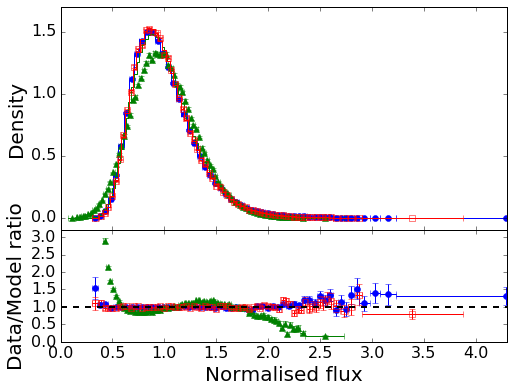

In [24]:
fig = plt.subplots(2,1,figsize=(8,6))
gs1 = gridspec.GridSpec(3,3)
gs1.update(hspace=0)
ax1 = plt.subplot(gs1[:-1,:])
ax2 = plt.subplot(gs1[-1,:])

print "******Measuring, fitting and plotting flux distribution for real light curve******"
bedges, bcent, bwidths, cdens, cdens_err = mkfluxhist(norm_rate, 100, 20) 
p0 = [0.3, 0.0, 1.0]
result =  op.minimize(ChiSq_Integ, p0, args=(bedges,cdens,cdens_err), method='L-BFGS-B', 
                     bounds=[(0.0,None),(0.0,None),(None,None)])
print "Fit parameters [sigma, tau, ln(mu)] : ",result.x 
print "Chi-squared : ",result.fun," for ",len(cdens)-3," d.o.f" 
modens, modflux, modelvals = integrate_model(result.x, bedges)
my_plot_hist(bcent, bwidths, cdens, cdens_err, modflux, modens, modelvals, "blue", "o", "blue")

print "******Measuring, fitting and plotting flux distribution for K16 simulated light curve******"
bedges, bcent, bwidths, cdens, cdens_err = mkfluxhist(norm_rate_koen, 100, 20)
p0 = [0.3, 0.0, 1.0]
result =  op.minimize(ChiSq_Integ, p0, args=(bedges,cdens,cdens_err), method='L-BFGS-B', 
                     bounds=[(0.0,None),(0.0,None),(None,None)])
print "Fit parameters [sigma, tau, ln(mu)] : ",result.x 
print "Chi-squared : ",result.fun," for ",len(cdens)-3," d.o.f" 
modens, modflux, modelvals = integrate_model(result.x, bedges)
my_plot_hist(bcent, bwidths, cdens, cdens_err, modflux, modens, modelvals, "green", "^", "green")

print "******Measuring, fitting and plotting flux distribution for UMV05 simulated light curve******"
bedges, bcent, bwidths, cdens, cdens_err = mkfluxhist(norm_rate_exp, 100, 20)
p0 = [0.3, 0.0, 1.0]
result =  op.minimize(ChiSq_Integ, p0, args=(bedges,cdens,cdens_err), method='L-BFGS-B', 
                     bounds=[(0.0,None),(0.0,None),(None,None)])
print "Fit parameters [sigma, tau, ln(mu)] : ",result.x 
print "Chi-squared : ",result.fun," for ",len(cdens)-3," d.o.f" 
modens, modflux, modelvals = integrate_model(result.x, bedges)
my_plot_hist(bcent, bwidths, cdens, cdens_err, modflux, modens, modelvals, "red", "s", "None")

ax1.axes.xaxis.set_ticklabels([])
#plt.savefig("flux_hist.pdf", bbox_inches='tight')

plt.show()